# Feature selection - Squential Backward Selection

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_wine

#Load data
dataObj = load_wine()
X = dataObj.data
y = dataObj.target
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Standardization
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [2]:
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [3]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# Print result
for setf, score in zip(sbs.subsets_,sbs.scores_):
    setPrint = ", ".join(f"{i:1d}" for i in setf)
    print(f"Accuracy = {score:3.2f}: Features = {setPrint}")

Accuracy = 0.94: Features = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
Accuracy = 0.97: Features = 0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12
Accuracy = 1.00: Features = 0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12
Accuracy = 1.00: Features = 0, 1, 2, 3, 6, 7, 8, 9, 10, 12
Accuracy = 1.00: Features = 0, 1, 2, 3, 6, 7, 8, 10, 12
Accuracy = 1.00: Features = 0, 1, 2, 3, 6, 8, 10, 12
Accuracy = 1.00: Features = 0, 1, 3, 6, 8, 10, 12
Accuracy = 1.00: Features = 0, 1, 3, 6, 10, 12
Accuracy = 1.00: Features = 0, 1, 3, 10, 12
Accuracy = 0.94: Features = 0, 1, 10, 12
Accuracy = 0.97: Features = 0, 1, 10
Accuracy = 0.87: Features = 0, 10
Accuracy = 0.84: Features = 0


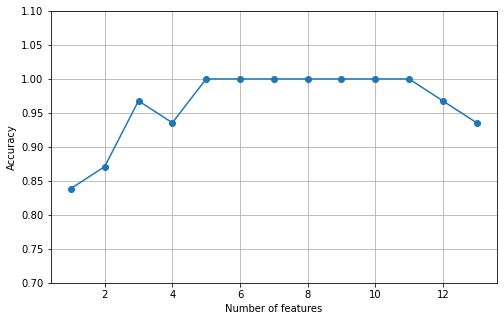

In [4]:
# Plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(k_feat, sbs.scores_, marker='o')
ax.set_ylim([0.7, 1.1])
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of features')
ax.grid()
plt.show()

In [5]:
# Print the chosen columns from 5 numbers of features (index=8)
cols = np.array(dataObj.feature_names)
k5 = list(sbs.subsets_[8])
print(k5)
print(cols[k5])

[0, 1, 3, 10, 12]
['alcohol' 'malic_acid' 'alcalinity_of_ash' 'hue' 'proline']


In [6]:
# Compare the accuracy 
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.9838709677419355
Test accuracy: 0.9444444444444444


In [7]:
knn.fit(X_train_std[:, k5], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k5], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k5], y_test))

Training accuracy: 0.9596774193548387
Test accuracy: 0.9629629629629629
